### Imports

In [2]:
import functools
import operator
import typing as t
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import typing_extensions as t_ext
from tqdm.notebook import tqdm
from transformers.models.auto.tokenization_auto import AutoTokenizer

In [3]:
tqdm.pandas()

In [4]:
COMBINED_DIR = Path('/home/jovyan/jigsaw-toxic/data/datasets/combined')
CCC2017_DIR = Path('/home/jovyan/jigsaw-toxic/data/datasets/ccc-2017-multilabel')

In [5]:
valid_labeled_df = pd.read_csv(CCC2017_DIR / 'valid_labeled.csv')

In [6]:
comment_to_label_dict = {}
for _, row in tqdm(valid_labeled_df.iterrows(), total=len(valid_labeled_df)):
    comment_to_label_dict[str(row['more_toxic'])] = str(row['more_toxic_bitmap_label'])
    comment_to_label_dict[str(row['less_toxic'])] = str(row['less_toxic_bitmap_label'])

  0%|          | 0/10108 [00:00<?, ?it/s]

In [29]:
# tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def _generate_text_token_len(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # df['more_toxic_token_len'] = df['more_toxic'].progress_apply(
    #     lambda text: len([
    #         i for i in tokenizer(text, add_special_tokens=True,
    #             truncation=True,
    #             padding='max_length',
    #             max_length=256)['input_ids']
    #         if i != 1
    #     ]))
    # df['less_toxic_token_len'] = df['less_toxic'].progress_apply(
    #     lambda text: len([
    #         i for i in tokenizer(text, add_special_tokens=True,
    #             truncation=True,
    #             padding='max_length',
    #             max_length=256)['input_ids']
    #         if i != 1
    #     ]))
    return df


def _load_labels(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['more_toxic_bitmap_label'] = df['more_toxic'].apply(lambda txt: comment_to_label_dict[txt])
    df['less_toxic_bitmap_label'] = df['less_toxic'].apply(lambda txt: comment_to_label_dict[txt])
    return df


def _bitmap_str_to_idx_set(label: str) -> t.Set[int]:
    return {i for i, b in enumerate(label.split(' ')) if int(b) == 1}


def _is_subset(row) -> int:
    more_idx_set = _bitmap_str_to_idx_set(row['more_toxic_bitmap_label'])
    less_idx_set = _bitmap_str_to_idx_set(row['less_toxic_bitmap_label'])
    return int(less_idx_set.issubset(more_idx_set) and less_idx_set != more_idx_set)


def _is_subset_reversed(row) -> int:
    more_idx_set = _bitmap_str_to_idx_set(row['more_toxic_bitmap_label'])
    less_idx_set = _bitmap_str_to_idx_set(row['less_toxic_bitmap_label'])
    return int(more_idx_set.issubset(less_idx_set) and less_idx_set != more_idx_set)


@dataclass
class ModelConfig:
    model_name: str
    best_epoch: int

    @property
    def error_csv_path(self) -> str:
        return f'/home/jovyan/jigsaw-toxic/artifacts/{self.model_name}/{self.best_epoch}.csv'

    def get_df(self) -> pd.DataFrame:
        df = pd.read_csv(self.error_csv_path)
        df['id'] = df.progress_apply(lambda row: row['less_toxic'] + ' ' + row['more_toxic'], axis=1)
        df = _generate_text_token_len(df)
        df = _load_labels(df)
        df['is_subset'] = df.progress_apply(_is_subset, axis=1)
        df['is_subset_reversed'] = df.progress_apply(_is_subset_reversed, axis=1)
        return df


model_list = [
    ModelConfig(
        model_name='ccc-2017-multilabel-harder-cls-loss_0p5-v2-valfreq_dynamic_v1',
        best_epoch=26,
    ),
    ModelConfig(
        model_name='ubtc-multireg-w50-cos_warmup-opt-2ep-ut_roberta-valfreq_dynamic_v1-seed_42',
        best_epoch=14,
    ),
    # ModelConfig(
    #     model_name='margin-ranking-ruddit-v1-no-quotes-mse-0_5',
    #     best_epoch=7,
    # ),
    # ModelConfig(
    #     model_name='margin-ranking-offenseval-2020-v1',
    #     best_epoch=13,
    # ),
    # ModelConfig(
    #     model_name='ccc-2017-multilabel-harder',
    #     best_epoch=9),
    # ModelConfig(
    #     model_name='ccc-2017-multilabel-harder-cls-loss_0p5',
    #     best_epoch=5),
    # ModelConfig(
    #     model_name='ccc-2017-multilabel-harder-cls-loss_dynamic_step3',
    #     best_epoch=2),
    # ModelConfig(
    #     model_name='ccc-2017-multilabel-harder-cls-loss_0p5-blind-regressor',
    #     best_epoch=9),
]

### Data loading

In [30]:
df_dict: t.Dict[str, pd.DataFrame] = {m.model_name: m.get_df() for m in model_list}

  0%|          | 0/10108 [00:00<?, ?it/s]

  0%|          | 0/10108 [00:00<?, ?it/s]

  0%|          | 0/10108 [00:00<?, ?it/s]

  0%|          | 0/10108 [00:00<?, ?it/s]

  0%|          | 0/10108 [00:00<?, ?it/s]

  0%|          | 0/10108 [00:00<?, ?it/s]

### Label analysis

In [31]:
ccc2017_df = df_dict['ccc-2017-multilabel-harder-cls-loss_0p5-v2-valfreq_dynamic_v1']
ubtc_df = df_dict['ubtc-multireg-w50-cos_warmup-opt-2ep-ut_roberta-valfreq_dynamic_v1-seed_42']

In [32]:
def get_identical_label_scores(df: pd.DataFrame):
    ok_df = df[df['error'] == 0.0]
    err_df = df[df['error'] > 0.0]
    print(len(ok_df[ok_df['more_toxic_bitmap_label'] == ok_df['less_toxic_bitmap_label']]) / len(ok_df))
    print(len(err_df[err_df['more_toxic_bitmap_label'] == err_df['less_toxic_bitmap_label']]) / len(err_df))

In [33]:
def get_is_subset_scores(df: pd.DataFrame):
    ok_df = df[df['error'] == 0.0]
    err_df = df[df['error'] > 0.0]
    print(len(ok_df[ok_df['is_subset'] == 1]) / len(ok_df))
    print(len(err_df[err_df['is_subset'] == 1]) / len(err_df))

def get_is_subset_reversed_scores(df: pd.DataFrame):
    ok_df = df[df['error'] == 0.0]
    err_df = df[df['error'] > 0.0]
    print(len(ok_df[ok_df['is_subset_reversed'] == 1]) / len(ok_df))
    print(len(err_df[err_df['is_subset_reversed'] == 1]) / len(err_df))

In [34]:
get_identical_label_scores(ccc2017_df)
get_identical_label_scores(ubtc_df)

0.2954847277556441
0.5543056633048875
0.2967252396166134
0.5489214175654854


In [35]:
get_is_subset_scores(ccc2017_df)
get_is_subset_scores(ubtc_df)

0.6634794156706507
0.06710628394103957
0.6481629392971247
0.11556240369799692


In [36]:
get_is_subset_reversed_scores(ccc2017_df)
get_is_subset_reversed_scores(ubtc_df)

0.028552456839309428
0.35686578743211794
0.041001064962726305
0.31856702619414484


In [38]:
len(ccc2017_df[ccc2017_df['is_subset_reversed'] == 1]) / len(ccc2017_df)

0.11228729719034428

### How many error samples do we have in common?

In [6]:
def _get_error_id_set_dict(df_dict: t.Dict[str, pd.DataFrame]) -> t.Dict[str, t.Set[str]]:
    error_id_set_dict: t.Dict[str, t.Set[str]] = {}
    common_id_set: t.Optional[t.Set[str]] = None
    for model_name, df in df_dict.items():
        error_df = df[df['error'] > 0]
        error_id_set = set(error_df['id'].unique())
        common_id_set = common_id_set & error_id_set if common_id_set is not None else error_id_set
        error_id_set_dict[model_name] = error_id_set
    assert common_id_set is not None
    error_id_set_dict['common'] = common_id_set
    return error_id_set_dict

In [7]:
error_id_set_dict = _get_error_id_set_dict(df_dict)

ccc-2017-multilabel-v4-cls-loss_0p9-reg-toxic_bert-noapprox-valfreq_dynamic_v1: 3167
certainty: 0.7411300919842313


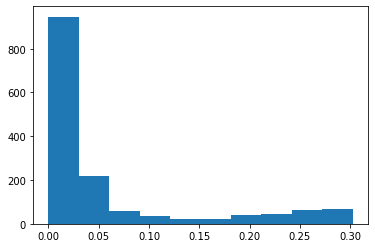

margin-ranking-ruddit-v1-no-quotes-mse-0_5: 3091
certainty: 0.7411300919842313


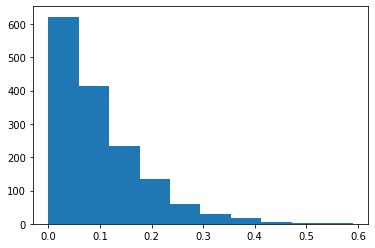

common: 1522


In [8]:
for model_name, id_set in error_id_set_dict.items():
    print(f'{model_name}: {len(id_set)}')
    if model_name != 'common':
        df = df_dict[model_name]
        common_error_df = df[df['id'].isin(error_id_set_dict['common'])]
        print(f'certainty: {len(common_error_df[common_error_df["certainty"] < 1.0]) / len(common_error_df)}')
        plt.show(plt.hist(common_error_df['error']))

In [15]:
def _get_error_df(error_id_set_dict: t.Dict[str, t.Set[str]]) -> pd.DataFrame:
    comment_to_count_dict = {}
    for cid in functools.reduce(operator.ior, error_id_set_dict.values()):
        comment_to_count_dict[cid] = len([_ for _, comment_set in error_id_set_dict.items() if cid in comment_set])
    return pd.DataFrame([{'id': cid, 'mistaken_model_count': mmc} for cid, mmc in comment_to_count_dict.items()])

In [16]:
error_df = _get_error_df(error_id_set_dict)

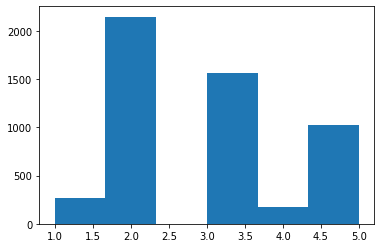

In [20]:
plt.hist(error_df['mistaken_model_count'], bins=6);

In [21]:
len(error_df[error_df['mistaken_model_count'] < 3]) / len(error_df)

0.46594636311016785

In [13]:
def _sample_one(df: pd.DataFrame):
    row = df.sample(n=1).iloc[0]
    print(f'ERROR: {row["error"]}')
    print(f'CERTAINTY: {row["certainty"]}')
    print('=' * 10)
    print('LESS TOXIC:')
    print(str(row['less_toxic']))
    print('=' * 10)
    print('MORE TOXIC:')
    print(str(row['more_toxic']))

In [14]:
_df = df_dict['ccc-2017-multilabel-v3-cls-att-blind-reg']
_id_set = error_id_set_dict['common']
_sample_one(_df[_df['id'].isin(_id_set)])

ERROR: 0.0584297031164169
CERTAINTY: 0.6666666666666666
LESS TOXIC:
"
""Primary sources are generally not acceptable.""  Bwa ha ha ha ha ha.  Seriously?  Are you completely stoned or drunk?  You are certainly not a researcher, historian or even a student to make such a ridiculous and derelict statement.  Indeed, you expose yourself to ridicule, scorn, and certainly to the laughter of ANY serious student, writer, and certainly to the Titanic community.  We will start with my personal Facebook page, and go from there.  Too bad for you that you can't delete your ill-advised and stupid remark.  And no doubt about it, it was stupid beyond any means of defense."
MORE TOXIC:
"

 Miro quote 

""in his words ""murder"" and ""assassinate"" and or ""rape"" them"" Can we find a source for this refrence, prehaps an in-context quote?"


In [20]:
token = 'bitch'
filter_less_contains = _df['less_toxic'].str.lower().str.contains(token)
filter_more_contains = _df['more_toxic'].str.lower().str.contains(token)
less_toxic_total = len(_df[filter_less_contains])
more_toxic_total = len(_df[filter_more_contains])
less_toxic_only = len(_df[filter_less_contains & ~filter_more_contains])
more_toxic_only = len(_df[~filter_less_contains & filter_more_contains])

print(f'less_toxic_total = {less_toxic_total}')
print(f'more_toxic_total = {more_toxic_total}')
print(f'less_toxic_only = {less_toxic_only}')
print(f'more_toxic_only = {more_toxic_only}')

less_toxic_total = 111
more_toxic_total = 467
less_toxic_only = 104
more_toxic_only = 460
